# Lecture 14 - Bayesian Optimization for Synthesis Conditions

```{contents}
:local:
:depth: 1
```

## Learning goals

- Explain the ideas behind **Bayesian Optimization** for expensive experiments.
- Define **prior belief**, **surrogate model** (GP, RF, small NN), and **acquisition function** (EI, UCB, PI, greedy).
- Code the BO loop step by step: fit surrogate, compute acquisition, pick next point, update data.
- Run a chemistry case study: toy **Suzuki coupling** with three controllable factors (time, temperature, concentration) to optimize yield.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1rmLQ2MKbReYka9tDFUZYK9u9xbcARNS8?usp=sharing)
---

## 1. Setup

In [1]:
# 1.1 Imports and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Callable, Tuple

# scikit-learn pieces
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)
plt.rcParams["figure.figsize"] = (5.2, 3.6)
plt.rcParams["axes.grid"] = True

# Small helpers for plotting
def parity(y_true, y_pred, title="Parity"):
    plt.scatter(y_true, y_pred, alpha=0.6)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi], "k--", lw=1)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def line_plot_with_ci(x, mean, std, title="", xlabel="x", ylabel="y"):
    idx = np.argsort(x.ravel())
    x_ord = x.ravel()[idx]
    m_ord = mean.ravel()[idx]
    s_ord = std.ravel()[idx]
    plt.plot(x_ord, m_ord, lw=2)
    plt.fill_between(x_ord, m_ord - 1.96*s_ord, m_ord + 1.96*s_ord, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## 2. What is Bayesian Optimization

Bayesian Optimization (BO) is a strategy to optimize an unknown objective $f(x)$ when evaluations are expensive. Think of $f(x)$ as a reaction yield produced by a full experiment. We want to find $x^*$ that maximizes $f(x)$ using as few experiments as possible.

The workflow:

1. **Prior belief** about $f$ (for example a GP prior).  
2. **Surrogate model** that maps $x \mapsto$ a predictive **mean** $\mu(x)$ and **uncertainty** $\sigma(x)$.  
3. **Acquisition function** $a(x)$ that scores how attractive $x$ is to try next, combining exploration and exploitation.  
4. **Update** the dataset with the new measurement and refit the surrogate.

We repeat 2 to 4 until the budget is used.

### 2.1 A tiny 1D objective for intuition

We define a 1D function as a stand-in for an expensive lab run. The optimizer only sees measured points.

x_grid shape: (400, 1) y_grid shape: (400, 1)


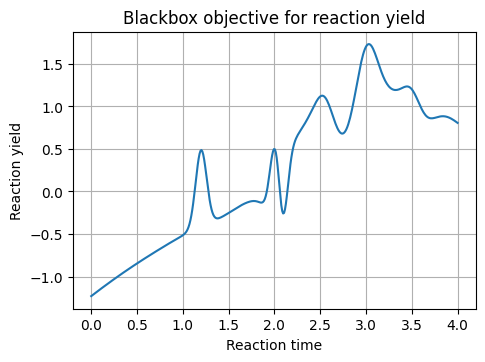

In [2]:
# 2.1 A 1D "hidden" objective
# Target points that the true function must pass through
X_knots = np.array([2.0, 3.0, 3.5]).reshape(-1, 1)
y_knots = np.array([0.5, 1.7, 1.2]).reshape(-1, 1)

# Challenging baseline that is high on [0, 2]
def f_base(x):
    x = np.asarray(x, dtype=float)
    left  = 1.0 / (1.0 + np.exp(-30.0*(x - 0.15)))
    right = 1.0 / (1.0 + np.exp( 30.0*(x - 1.95)))
    plateau = 1.8 * left * (1.0 - right)
    inner_peak = 0.9 * np.exp(-0.5*((x - 1.20)/0.06)**2)
    cliff = -1.2 * (1.0 / (1.0 + np.exp(-40.0*(x - 2.05))))
    valley = -0.6 * np.exp(-0.5*((x - 2.10)/0.05)**2)
    ripples = 0.22 * np.sin(8.5*x) * np.exp(-0.5*((x - 3.0)/0.7)**2)
    bumps = (
        0.35*np.exp(-0.5*((x - 2.55)/0.10)**2) +
        0.28*np.exp(-0.5*((x - 3.35)/0.12)**2)
    )
    trend = 0.06*x - 0.12*(x - 3.2)**2
    return plateau + inner_peak + cliff + valley + ripples + bumps + trend

taus = np.array([0.08, 0.12, 0.10])  # widths for the 3 RBFs
def rbf(x, c, tau):
    return np.exp(-0.5*((x - c)/tau)**2)

# Build interpolation system A w = residual
A = np.zeros((3,3))
for i, xi in enumerate(X_knots.ravel()):
    for j, (cj, tj) in enumerate(zip(X_knots.ravel(), taus)):
        A[i, j] = rbf(xi, cj, tj)

residual = y_knots.ravel() - f_base(X_knots.ravel())
w = np.linalg.solve(A, residual)  # weights for the RBF corrections

# Final true function that passes through the three knots
def f_true_1d(x):
    x = np.asarray(x, dtype=float)
    base = f_base(x)
    corr = (w[0]*rbf(x, X_knots[0,0], taus[0]) +
            w[1]*rbf(x, X_knots[1,0], taus[1]) +
            w[2]*rbf(x, X_knots[2,0], taus[2]))
    return base + corr

# Grid for plotting the landscape
x_grid = np.linspace(0, 4.0, 400).reshape(-1, 1)
y_grid = f_true_1d(x_grid)

print("x_grid shape:", x_grid.shape, "y_grid shape:", y_grid.shape)
plt.plot(x_grid, y_grid)
plt.title("Blackbox objective for reaction yield")
plt.xlabel("Reaction time")
plt.ylabel("Reaction yield")
plt.show()

```{admonition} Try it
Try a different set of `X_knots` and `y_knots` and rebuild `f_true_1d`. Does BO still find the right peak quickly?
```

## 3. Gaussian Process surrogate: prior, posterior, kernel


A **Gaussian Process (GP)** defines a distribution over functions. You can think of it as a smooth prior belief about how $f$ behaves.

- *Prior*: Your belief about the function before you see any data. $f(x) \sim \mathcal{GP}(m(x), k(x, x'))$ with mean $m(x)$ (often zero) and kernel $k$.
- *Posterior*: After observing data $\mathcal{D} = \{(x_i, y_i)\}$, the GP produces a **posterior** with mean $\mu(x)$ and standard deviation $\sigma(x)$ at any new $x$.

Key knob: the **kernel** (RBF, Matern, etc.) and its **length scale** which controls smoothness. We will use RBF and Matern. A kernel (also called a covariance function) is the mathematical function that encodes how similar two input points are and how correlated their function values should be.




Now,
Imagine you want to optimize a synthetic reaction yield (say, % yield of a new product).

**Prior**: Before running any experiments, you have a belief about how yield depends on conditions (e.g., you assume the relation between yield and temperature like smooth sin wave). The prior says: “Yields at nearby temperatures are likely similar.”

**Kernel**:
1) If you choose an RBF kernel, you are assuming the yield curve is very smooth (small changes in temperature or catalyst concentration won’t cause sudden jumps).

2) If you choose a Matern kernel with small smoothness parameter, you allow for more abrupt changes, which might make sense if you expect sharp phase transitions or catalyst deactivation.

**Posterior**: After you actually run 5 experiments at different temperatures and record yields, the GP updates. Now:

1) At the tested temperatures, you have high confidence (low uncertainty).

2) At untested ones, you still predict yields, but with wider error bars.

The posterior reflects both your data and your initial assumption (kernel).


### 3.1 Draw function samples from the prior

Below let's look at sample from a GP prior to feel how kernels shape functions.

Prior sample matrix shape: (400, 3)


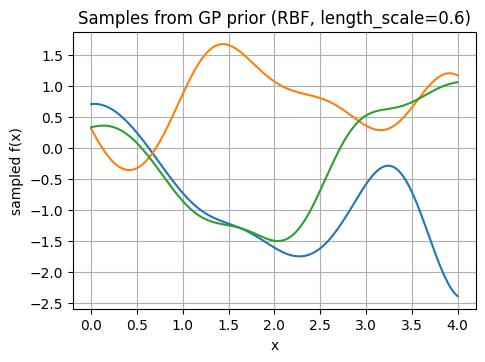

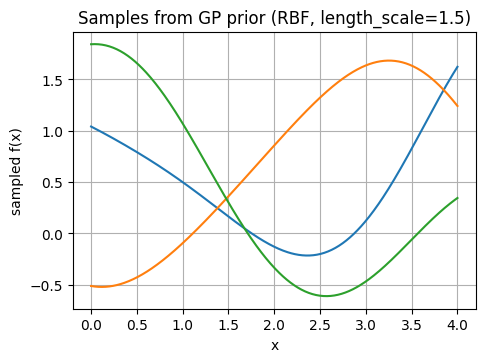

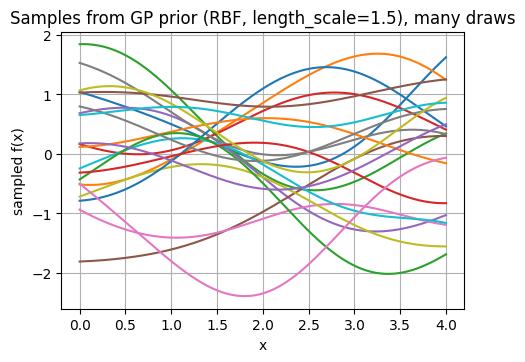

In [3]:
kernel_prior = C(1.0) * RBF(length_scale=0.6) # ConstantKernel + RBF
gpr_prior = GaussianProcessRegressor(kernel=kernel_prior, alpha=1e-8, normalize_y=False)  # not fitted
ys = gpr_prior.sample_y(x_grid, n_samples=3, random_state=1)

print("Prior sample matrix shape:", ys.shape)  # 400 x 3
plt.plot(x_grid, ys)
plt.title("Samples from GP prior (RBF, length_scale=0.6)")
plt.xlabel("x")
plt.ylabel("sampled f(x)")
plt.show()

# Try a longer length scale
kernel_prior2 = C(1.0) * RBF(length_scale=1.5)
gpr_prior2 = GaussianProcessRegressor(kernel=kernel_prior2, alpha=1e-8)
ys2 = gpr_prior2.sample_y(x_grid, n_samples=3, random_state=2)

plt.plot(x_grid, ys2)
plt.title("Samples from GP prior (RBF, length_scale=1.5)")
plt.xlabel("x")
plt.ylabel("sampled f(x)")
plt.show()

# Try more samples
kernel_prior3 = C(1.0) * RBF(length_scale=1.5)
gpr_prior3 = GaussianProcessRegressor(kernel=kernel_prior3, alpha=1e-8)
ys3 = gpr_prior3.sample_y(x_grid, n_samples=20, random_state=2)

plt.plot(x_grid, ys3)
plt.title("Samples from GP prior (RBF, length_scale=1.5), many draws")
plt.xlabel("x")
plt.ylabel("sampled f(x)")
plt.show()

### 3.2 Fit GP posterior on a few points

We start with 3 points `(2, 0.5)`, `(3, 1.7)`, `(3.5, 1.2)`.
Think about we run 3 reactions and got the actual yields.

Learned kernel: 1**2 * RBF(length_scale=0.293)


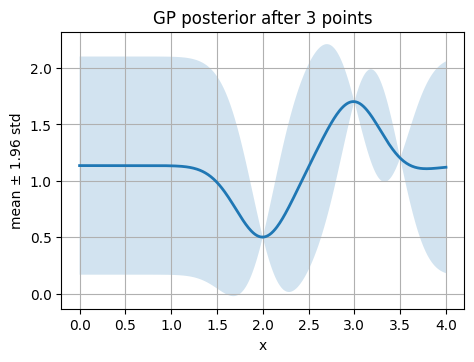

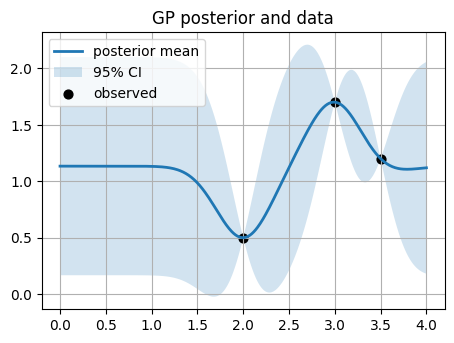

In [4]:
# 3.2 Initial data
X_list= [[2], [3], [3.5]]
y_list = [[0.5], [1.7], [1.2]]

X_init= np.array(X_list)
y_init = np.array(y_list)

# Build a GP
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.8, length_scale_bounds=(1e-2, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=3, normalize_y=True, random_state=0)

gp.fit(X_init, y_init)

print("Learned kernel:", gp.kernel_)

# Predict posterior mean and std on a dense grid
mu, std = gp.predict(x_grid, return_std=True)
line_plot_with_ci(x_grid, mu, std, title="GP posterior after 3 points", xlabel="x", ylabel="mean ± 1.96 std")

# Overlay data
plt.plot(x_grid, mu, lw=2, label="posterior mean")
plt.fill_between(x_grid.ravel(), mu - 1.96*std, mu + 1.96*std, alpha=0.2, label="95% CI")
plt.scatter(X_init, y_init, c="k", s=40, label="observed")
plt.title("GP posterior and data")
plt.legend()
plt.show()

```{admonition} ⏰ **Exercise**
Swap RBF for `Matern(length_scale=0.8, nu=2.5)`. Compare uncertainty bands. Which kernel handles sharper bumps better?
```
The **confidence interval (CI) band** you see in the GP plots (the shaded area between `mu ± 1.96*std`) comes directly from the **posterior distribution** of the Gaussian Process.
where:
- mu(x) is the posterior mean (the “best guess”).  
- sigma(x) is the posterior standard deviation (the uncertainty).  
- A Gaussian distribution has about **95% probability** that the true value lies within ±1.96 standard deviations of the mean.  


## 4. Acquisition functions: EI, UCB, PI, greedy


An **acquisition function** $a(x)$ scores how useful a new evaluation at $x$ would be. It uses $\mu(x)$ and $\sigma(x)$ from the surrogate.

We will maximize the acquisition (so higher is better) for **maximization** problems.

Let $y^+$ be the best observed value so far and $\xi \ge 0$ a small margin to encourage exploration.

- **Expected Improvement**  
  $$
  \mathrm{EI}(x) = (\mu(x) - y^+ - \xi)\,\Phi(z) + \sigma(x)\,\phi(z)
  $$
  where $z = \frac{\mu(x) - y^+ - \xi}{\sigma(x)}$, and $\Phi$ and $\phi$ are the CDF and PDF of the standard normal.

- **Upper Confidence Bound**  
  $$
  \mathrm{UCB}(x) = \mu(x) + \kappa\,\sigma(x)
  $$
  where $\kappa > 0$ controls exploration.

- **Probability of Improvement**  
  $$
  \mathrm{PI}(x) = \Phi\!\left(\frac{\mu(x) - y^+ - \xi}{\sigma(x)}\right)
  $$

- **Greedy** (exploitation only)  
  $$
  a(x) = \mu(x)
  $$


### 4.1 Implement acquisition functions
We write short functions that accept arrays of $\mu$, $\sigma$, and the current best $y^+$.

In [5]:
# 4.1 Acquisition functions
def acq_ei(mu, sigma, y_best, xi=0.01):
    sigma = np.maximum(sigma, 1e-12)
    z = (mu - y_best - xi) / sigma
    return (mu - y_best - xi) * norm.cdf(z) + sigma * norm.pdf(z)

def acq_ucb(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

def acq_pi(mu, sigma, y_best, xi=0.01):
    sigma = np.maximum(sigma, 1e-12)
    z = (mu - y_best - xi) / sigma
    return norm.cdf(z)

def acq_greedy(mu):
    return mu

# Sanity check: simple arrays
mu_test = np.array([0.1, 0.2, 0.5])
sd_test = np.array([0.05, 0.1, 0.2])
print("EI:", acq_ei(mu_test, sd_test, y_best=0.15))
print("UCB:", acq_ucb(mu_test, sd_test, kappa=1.0))
print("PI:", acq_pi(mu_test, sd_test, y_best=0.15))
print("Greedy:", acq_greedy(mu_test))

EI: [0.00280512 0.06304388 0.34365756]
UCB: [0.15 0.3  0.7 ]
PI: [0.11506967 0.65542174 0.95543454]
Greedy: [0.1 0.2 0.5]


### 4.2 Visualize acquisition shapes

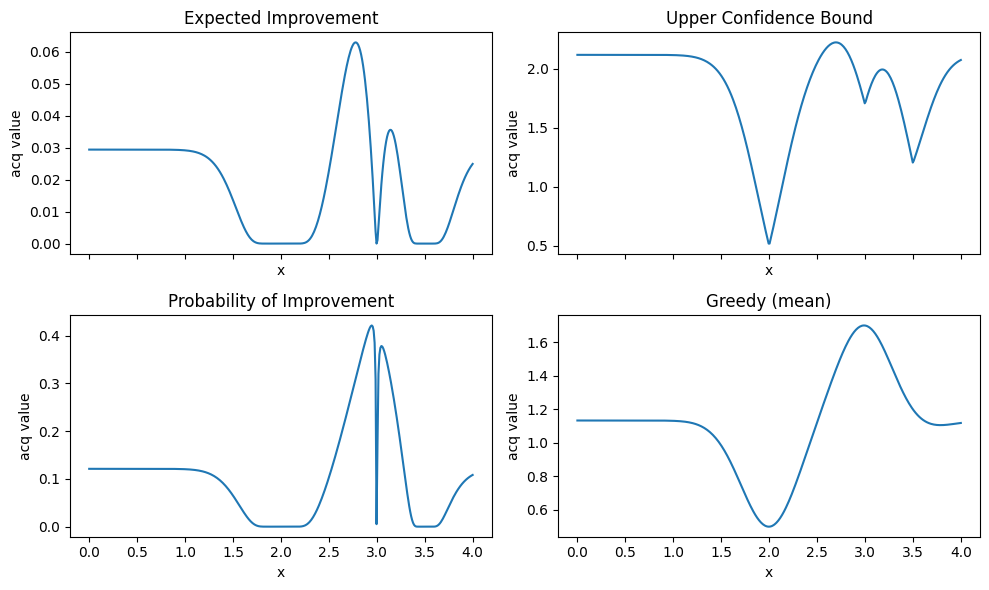

In [6]:
# 4.2 Acquisition profiles over x_grid with current GP
y_best = np.array(y_init).max()

mu, std = gp.predict(x_grid, return_std=True)
ei_vals = acq_ei(mu, std, y_best=y_best, xi=0.01)
ucb_vals = acq_ucb(mu, std, kappa=2.0)
pi_vals  = acq_pi(mu, std, y_best=y_best, xi=0.01)
greedy_v = acq_greedy(mu)

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.ravel()

axes[0].plot(x_grid, ei_vals); axes[0].set_title("Expected Improvement")
axes[1].plot(x_grid, ucb_vals); axes[1].set_title("Upper Confidence Bound")
axes[2].plot(x_grid, pi_vals);  axes[2].set_title("Probability of Improvement")
axes[3].plot(x_grid, greedy_v); axes[3].set_title("Greedy (mean)")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("acq value")
    ax.grid(False)
plt.tight_layout()
plt.show()

```{admonition} Tip
- EI and PI look at improvement over the current best.  
- UCB trades off mean and uncertainty with a single knob `kappa`.  
- Greedy ignores uncertainty and often gets stuck.
```

## 5. The BO loop in 1D step by step

We now implement the loop:

1. Fit surrogate to $(X, y)$.
2. Compute $\mu$, $\sigma$ on a candidate set.  
3. Compute acquisition $a(x)$ and pick $x_{next} = \arg\max a(x)$.
4. Run the experiment (here we call `f_true_1d`) to get $y_{next}$.
5. Append to data and go back to step 1.

We will do 15 to 20 iterations and look at the history.

### 5.1 Small utility: argmax on a grid

In [7]:
# 5.1 Argmax on a grid
def argmax_on_grid(values, grid):
    idx = np.argmax(values)
    return grid[idx:idx+1], idx

# Quick check
vals = np.array([0.1, 0.3, -0.2, 0.9, 0.4])
grid = np.array([10, 20, 30, 40, 50]).reshape(-1,1)
x_star, idx_star = argmax_on_grid(vals, grid)
x_star, idx_star

(array([[40]]), 3)

### 5.2 Run BO with EI

Iter 1: x_next=2.987468671679198, y_next=1.751929766965282, best_so_far=1.751929766965282


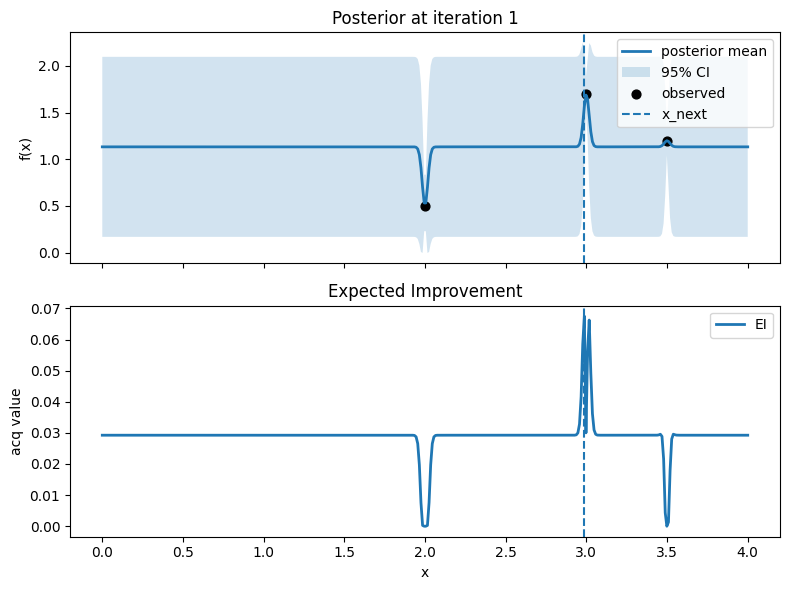

Iter 2: x_next=2.756892230576441, y_next=0.6551551807430195, best_so_far=1.751929766965282


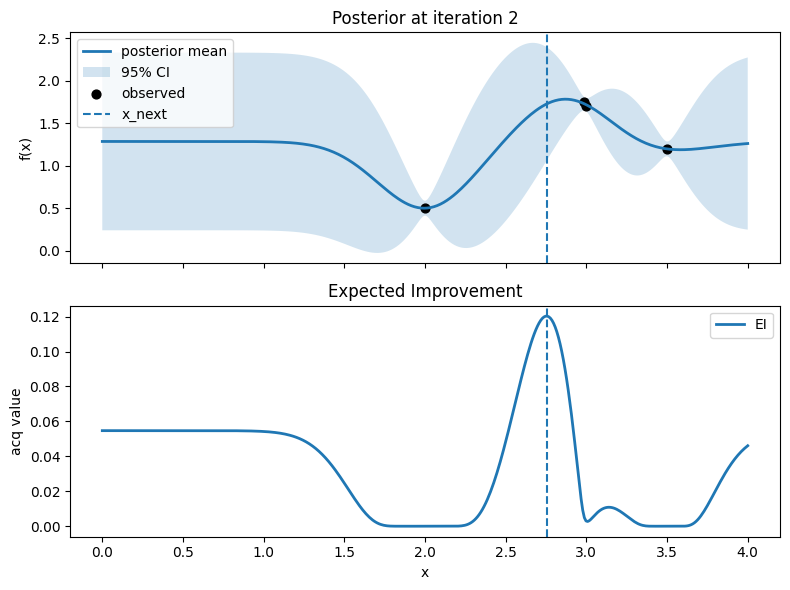

Iter 3: x_next=2.9373433583959896, y_next=1.440981135962244, best_so_far=1.751929766965282


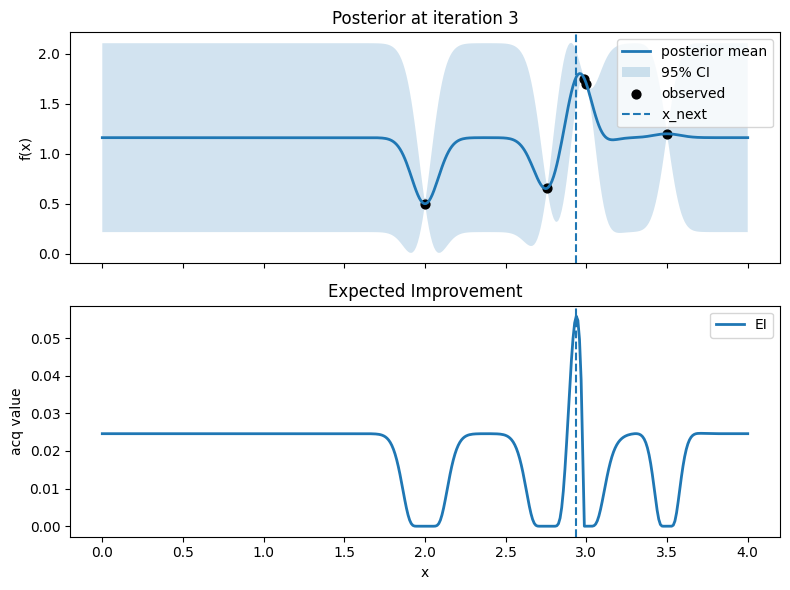

Iter 4: x_next=3.0977443609022552, y_next=1.5688864052195108, best_so_far=1.751929766965282


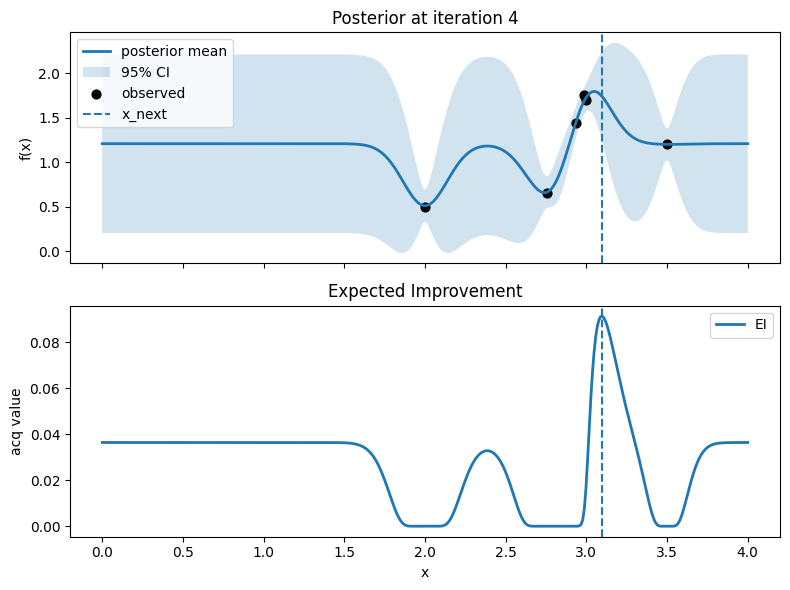

Iter 5: x_next=0.0, y_next=-1.1855296185337663, best_so_far=1.751929766965282


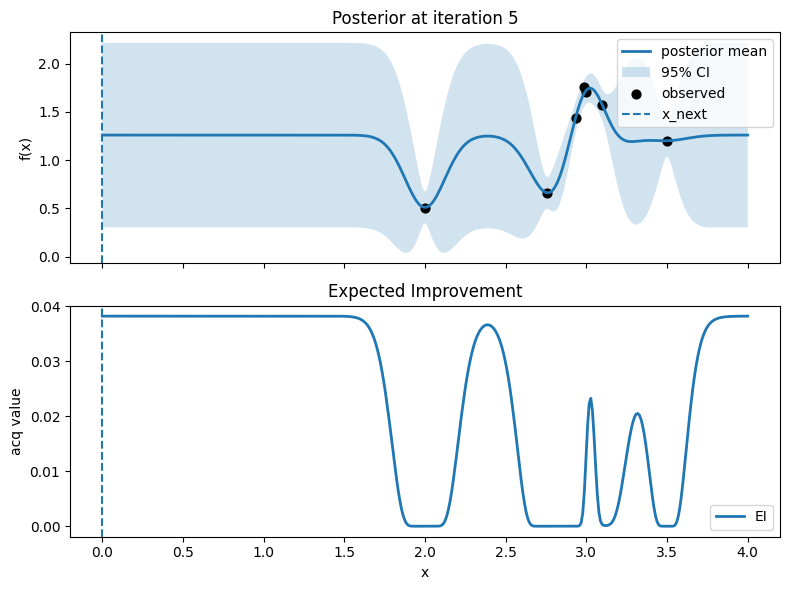

Iter 6: x_next=3.789473684210526, y_next=0.7607467191519236, best_so_far=1.751929766965282


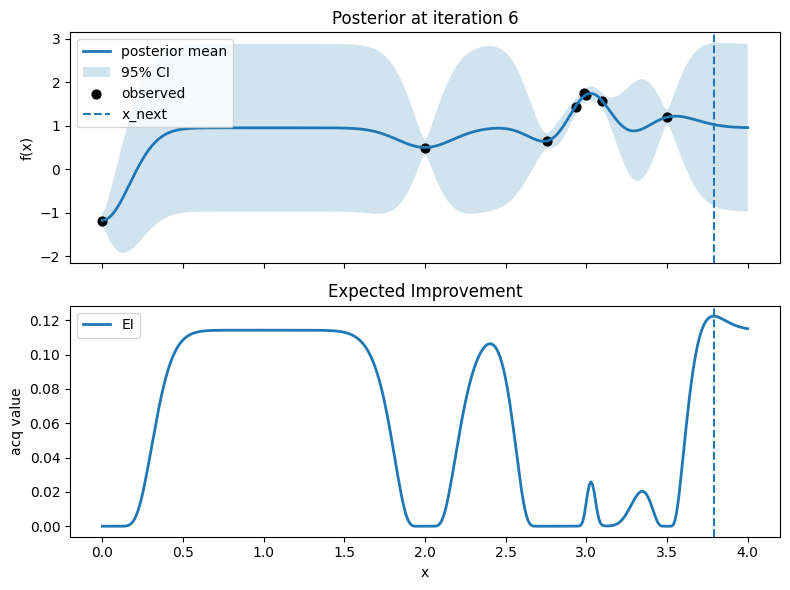

Iter 7: x_next=1.0225563909774436, y_next=-0.4062831800840925, best_so_far=1.751929766965282


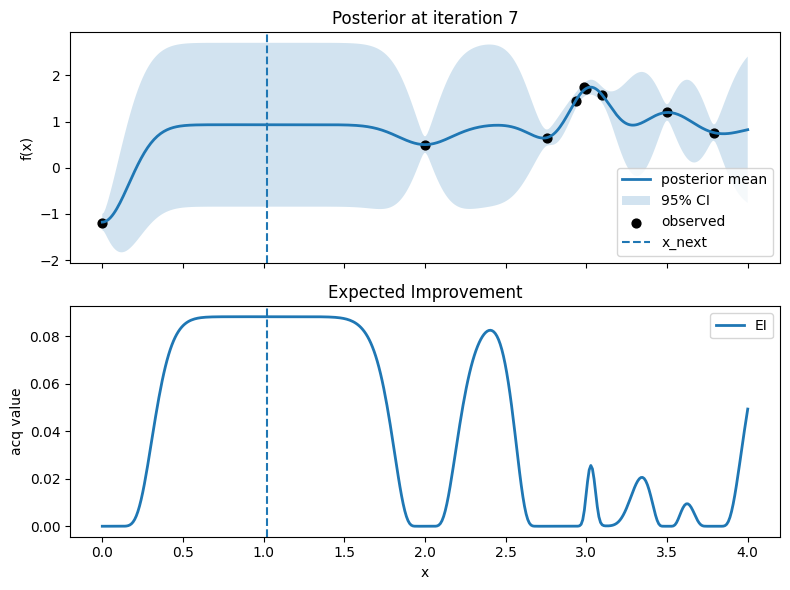

Iter 8: x_next=2.406015037593985, y_next=0.9081980588839931, best_so_far=1.751929766965282


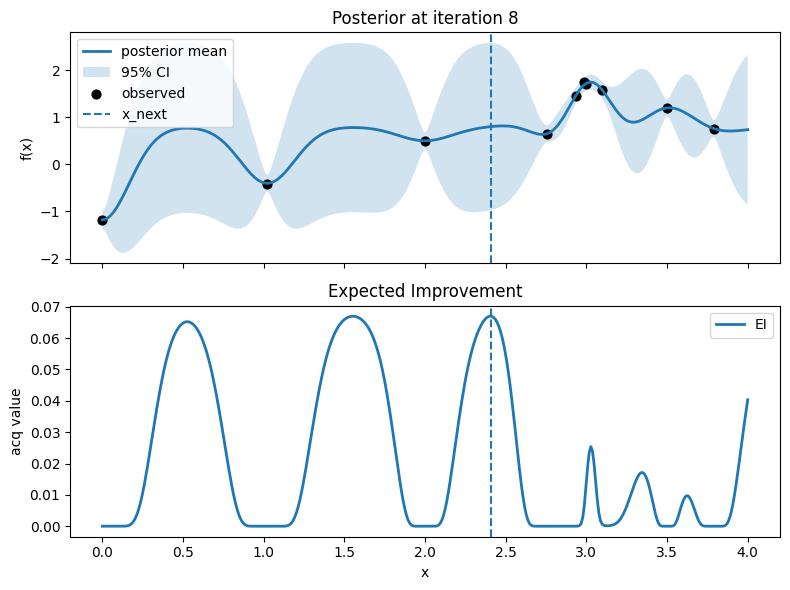

Iter 9: x_next=1.5538847117794485, y_next=-0.20037966426685516, best_so_far=1.751929766965282


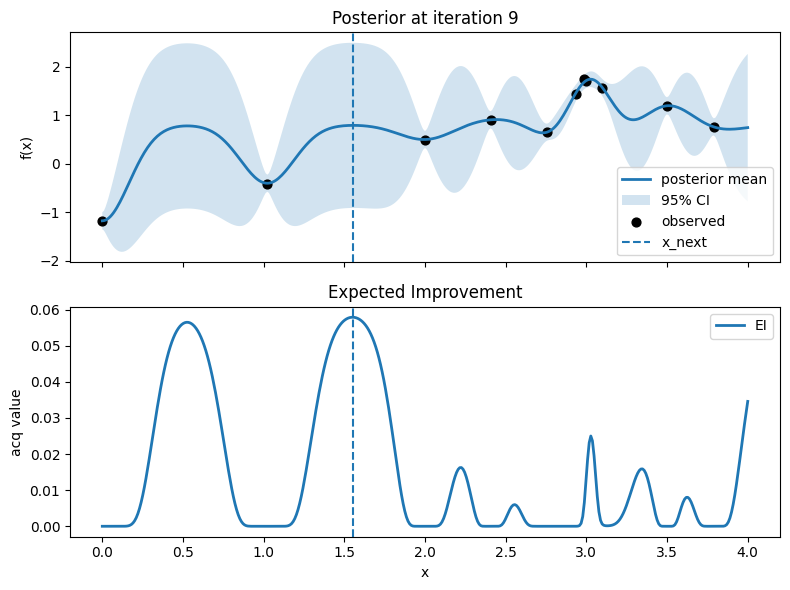

Iter 10: x_next=3.1378446115288217, y_next=1.4854980266232756, best_so_far=1.751929766965282


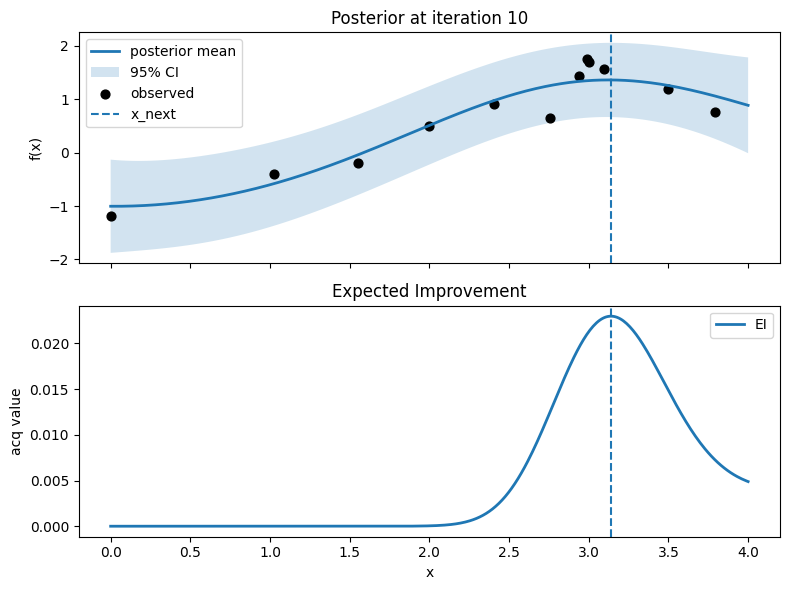

Iter 11: x_next=3.117794486215539, y_next=1.6351712270821586, best_so_far=1.751929766965282


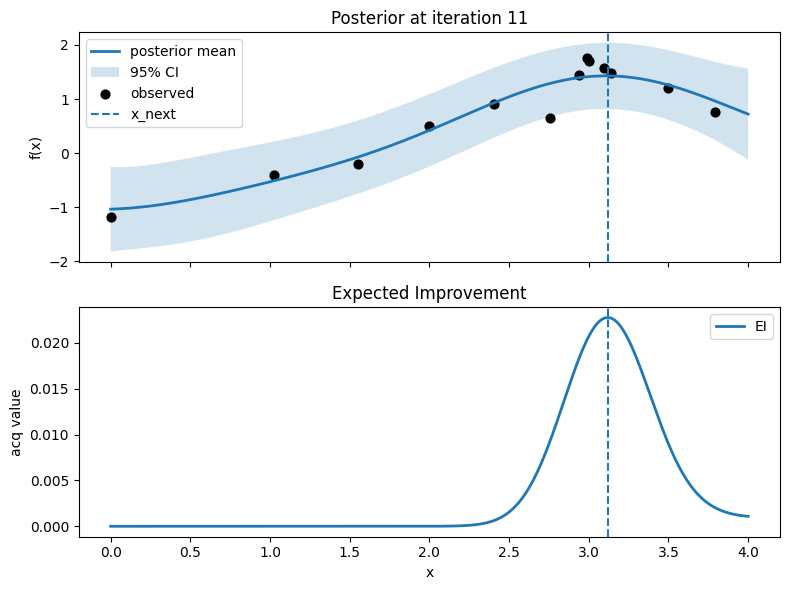

Iter 12: x_next=0.5413533834586466, y_next=-0.9191920723545901, best_so_far=1.751929766965282


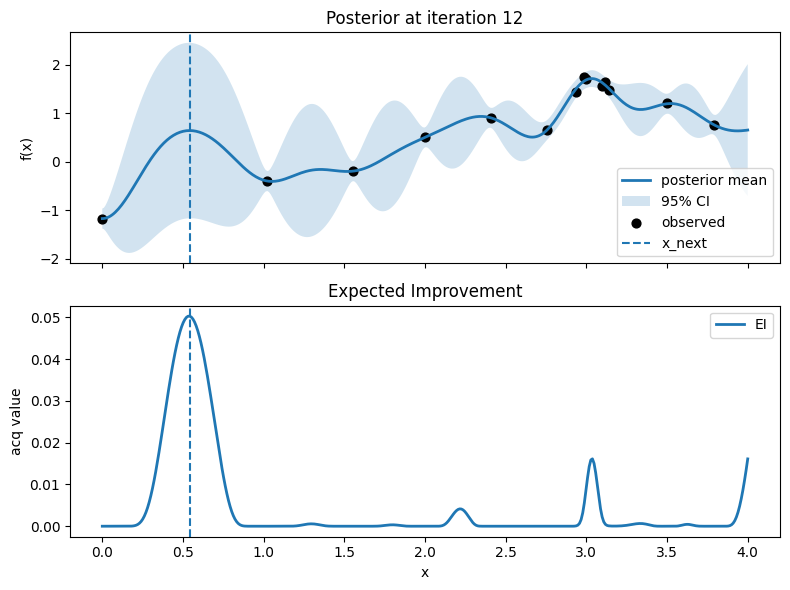

Iter 13: x_next=3.1278195488721803, y_next=1.51403716027239, best_so_far=1.751929766965282


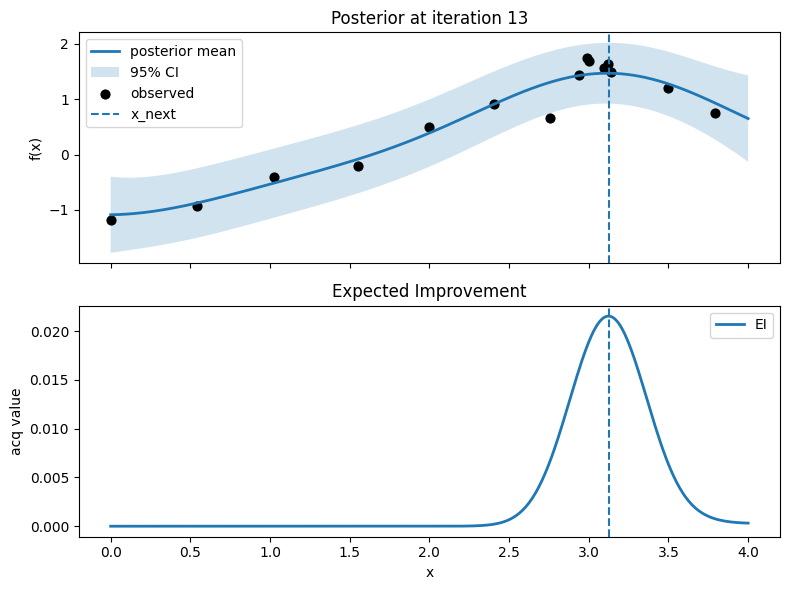

Iter 14: x_next=3.1278195488721803, y_next=1.5109553027396445, best_so_far=1.751929766965282


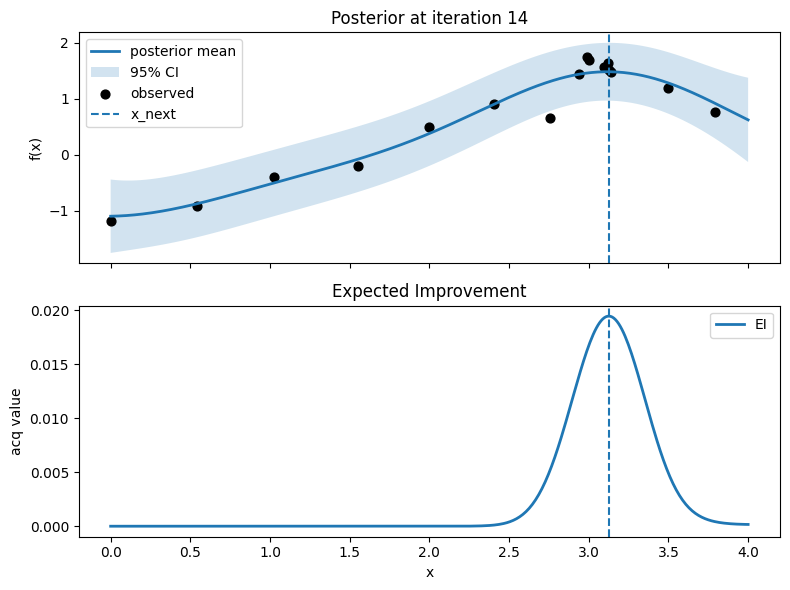

Iter 15: x_next=4.0, y_next=0.8618457095301242, best_so_far=1.751929766965282


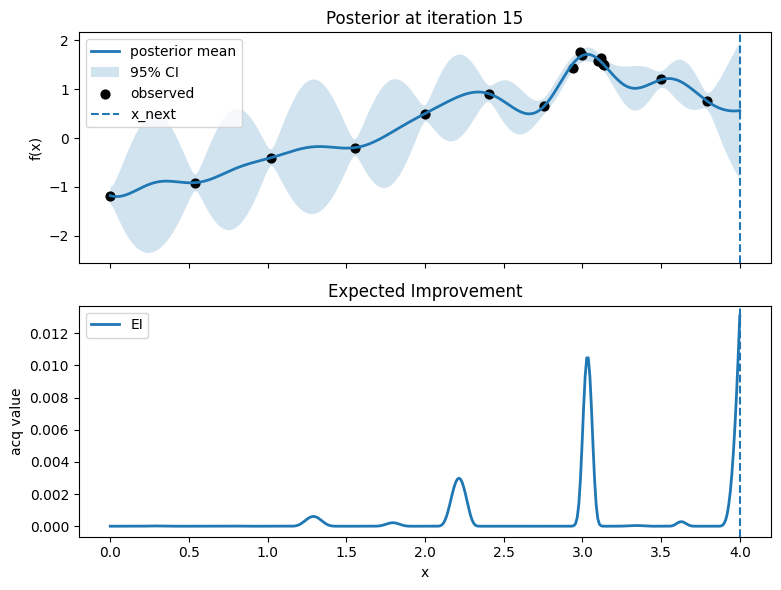

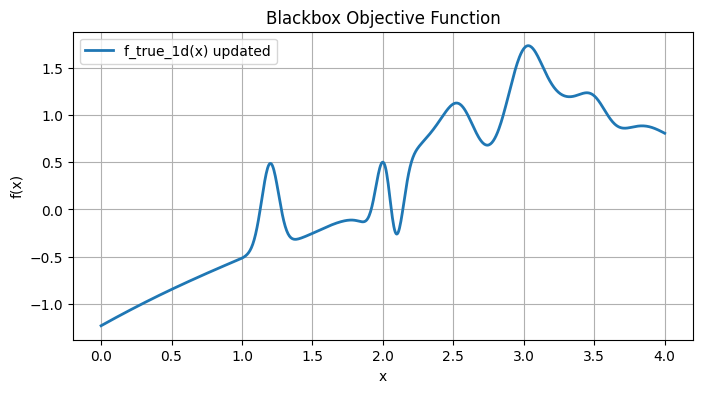

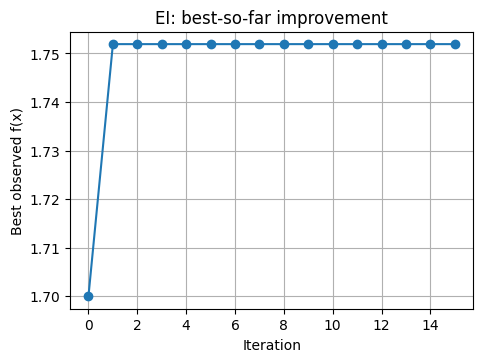

In [8]:
# ----- Initial data -----
X_init = np.array([[2.0], [3.0], [3.5]])
y_init = np.array([0.5, 1.7, 1.2])

# ----- Grid and RNG -----
x_grid = np.linspace(0.0, 4.0, 400).reshape(-1, 1)
rng = np.random.RandomState(1)

# ----- BO setup: GP with RBF + White -----
kernel = C(1.0) * RBF(length_scale=0.8) + WhiteKernel(noise_level=1e-2)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=3, random_state=1)

# ----- BO state -----
X = X_init.copy()
y = y_init.copy()
history_best = [y.max()]

# ----- Run 15 iterations with per-iteration plots -----
n_iter = 15
for t in range(1, n_iter + 1):
    # Fit surrogate
    gp.fit(X, y)

    # Posterior over grid
    mu, std = gp.predict(x_grid, return_std=True)

    # Acquisition on grid
    acq = acq_ei(mu, std, y_best=y.max(), xi=0.01)

    # Choose next point
    x_next, idx = argmax_on_grid(acq, x_grid)
    # Noisy observation from the true function
    y_next = f_true_1d(x_next) + rng.normal(0, 0.05, size=(1,))

    # Log iteration info
    print(f"Iter {t}: x_next={float(x_next)}, y_next={float(y_next)}, best_so_far={float(max(y.max(), y_next))}")

    # Plot: posterior (top) and EI (bottom)
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # Top: posterior mean and 95% CI, with observed points
    axes[0].plot(x_grid, mu, lw=2, label="posterior mean")
    axes[0].fill_between(x_grid.ravel(), mu - 1.96*std, mu + 1.96*std, alpha=0.2, label="95% CI")
    axes[0].scatter(X, y, c="k", s=40, label="observed")
    # Mark proposed point
    axes[0].axvline(float(x_next), linestyle="--", lw=1.5, label="x_next")
    axes[0].set_ylabel("f(x)")
    axes[0].set_title(f"Posterior at iteration {t}")
    axes[0].legend(loc="best")
    axes[0].grid(False)

    # Bottom: EI
    axes[1].plot(x_grid, acq, lw=2, label="EI")
    axes[1].axvline(float(x_next), linestyle="--", lw=1.5)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("acq value")
    axes[1].set_title("Expected Improvement")
    axes[1].legend(loc="best")
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()

    # Update data
    X = np.vstack([X, x_next])
    y = np.hstack([y, y_next.ravel()])
    history_best.append(y.max())

# Plot the true function on [0, 4]
xg = np.linspace(0, 4, 800)
y_true = f_true_1d(xg)

plt.figure(figsize=(8, 4))
plt.plot(xg, y_true, lw=2, label="f_true_1d(x) updated")
plt.title("Blackbox Objective Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

# Track best-so-far vs iteration
plt.plot(history_best, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best observed f(x)")
plt.title("EI: best-so-far improvement")
plt.show()

```{admonition} ⏰ **Exercise**
Replace EI with UCB using `kappa=2.5`. Plot the best-so-far curve. Which method reaches a good point faster on this function?
```

### 5.3 Where did BO sample

A healthy pattern often shows some early exploration across the space, then a focus on promising regions.

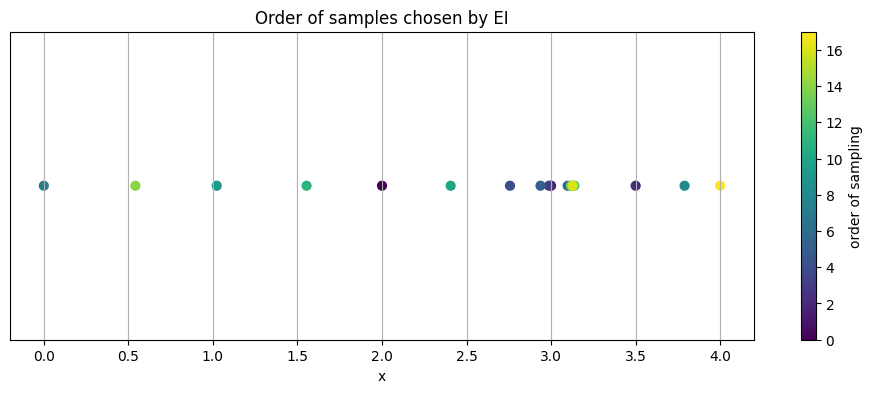

In [9]:
# 5.3 Visualize chosen locations on the x axis
plt.figure(figsize=(12, 4))
plt.scatter(X.ravel(), np.zeros_like(X.ravel()), c=np.arange(len(X)), cmap="viridis", s=40)
plt.colorbar(label="order of sampling")
plt.yticks([])
plt.xlabel("x")
plt.title("Order of samples chosen by EI")
plt.show()

## 6. Surrogate alternatives and simple diagnostics

Gaussian Processes are a common surrogate for low to moderate dimensional spaces. For higher dimensions or larger datasets, tree ensembles and small neural surrogates can help.

We try a **RandomForestRegressor** as a surrogate. Its mean is the average prediction across trees, and an uncertainty *proxy* is the **standard deviation across trees**.

### 6.1 Random Forest surrogate: mean and std from trees

In [10]:
# 6.1 RF surrogate: using tree-wise predictions for mean and std
def rf_mean_std(rf: RandomForestRegressor, Xc: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # collect predictions from each tree
    preds = np.stack([est.predict(Xc) for est in rf.estimators_], axis=1)  # shape (n, n_trees)
    mu = preds.mean(axis=1)
    sd = preds.std(axis=1)
    return mu, sd

# Tiny demo on a few random numbers
rf_demo = RandomForestRegressor(n_estimators=10, random_state=0).fit(x_grid, y_grid)
mu_demo, sd_demo = rf_mean_std(rf_demo, x_grid[:5])
mu_demo[:3], sd_demo[:3]

(array([-1.22631278, -1.22216741, -1.21224479]),
 array([0.00379929, 0.00331629, 0.00369172]))

### 6.2 BO loop with RF surrogate (EI)

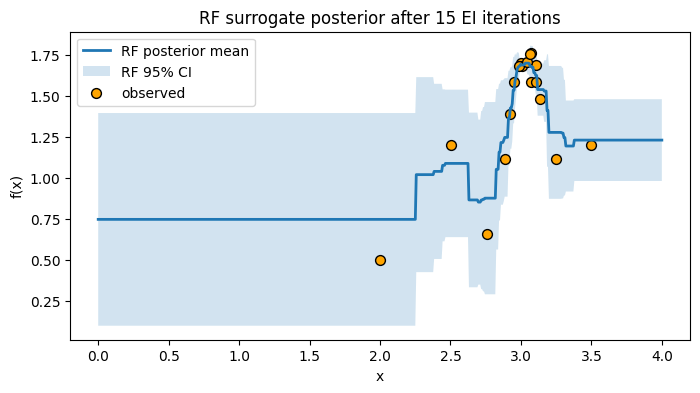

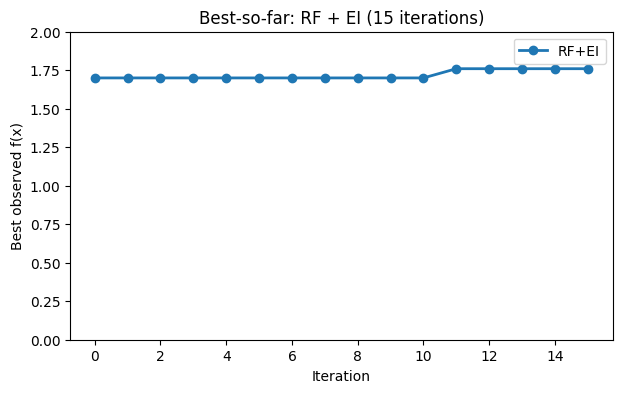

In [11]:
# RF surrogate + EI, 15 iterations
X_init = np.array([[2.0], [3.0], [3.5]])
y_init = np.array([0.5, 1.7, 1.2])

# Grid over [0, 4]
x_grid = np.linspace(0.0, 4.0, 600).reshape(-1, 1)

def rf_mean_std(rf: RandomForestRegressor, Xc: np.ndarray):
    preds = np.stack([est.predict(Xc) for est in rf.estimators_], axis=1)  # (n, n_trees)
    mu = preds.mean(axis=1)
    sd = preds.std(axis=1)
    return mu, sd

# EI using RF's Gaussian approximation
def acq_ei_from_mu_std(mu, sd, y_best, xi=0.01):
    mu = np.asarray(mu).ravel()
    sd = np.asarray(sd).ravel()
    z = np.zeros_like(mu)
    mask = sd > 0
    z[mask] = (mu[mask] - y_best - xi) / sd[mask]
    ei = np.zeros_like(mu)
    ei[mask] = (mu[mask] - y_best - xi) * norm.cdf(z[mask]) + sd[mask] * norm.pdf(z[mask])
    return ei

def argmax_on_grid(values, grid):
    i = int(np.argmax(values))
    return grid[i:i+1], i

def run_rf_bo_ei(n_iter=15, seed=1, noise_sd=0.05):
    rng = np.random.RandomState(seed)
    X = X_init.copy()
    y = y_init.copy()
    best_hist = [y.max()]
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=1,
        bootstrap=True,
        random_state=seed,
        n_jobs=-1
    )
    snapshots = {}

    for t in range(1, n_iter + 1):
        # Fit RF on current data
        rf.fit(X, y)

        # RF posterior over grid
        mu_rf, sd_rf = rf_mean_std(rf, x_grid)

        # EI on grid
        acq_vals = acq_ei_from_mu_std(mu_rf, sd_rf, y_best=y.max(), xi=0.01)

        # Choose next point
        x_next, _ = argmax_on_grid(acq_vals, x_grid)

        # Observe noisy value
        y_next = f_true_1d(x_next) + rng.normal(0, noise_sd, size=(1,))

        # Update data
        X = np.vstack([X, x_next])
        y = np.hstack([y, y_next.ravel()])
        best_hist.append(y.max())

        if t == n_iter:
            snapshots["final"] = (X.copy(), y.copy(), mu_rf.copy(), sd_rf.copy())

    return best_hist, snapshots

# Run RF+EI for 15 iterations
hist_rf_ei, snaps = run_rf_bo_ei(n_iter=15, seed=1, noise_sd=0.05)
X_obs, y_obs, mu_final, sd_final = snaps["final"]

# Plot RF posterior after 15 iterations
plt.figure(figsize=(8, 4))
plt.plot(x_grid, mu_final, lw=2, label="RF posterior mean")
plt.fill_between(x_grid.ravel(), mu_final - 1.96*sd_final, mu_final + 1.96*sd_final,
                 alpha=0.2, label="RF 95% CI")
plt.scatter(X_obs, y_obs, c="orange", s=50, edgecolor="k", label="observed")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("RF surrogate posterior after 15 EI iterations")
plt.legend()
plt.grid(False)
plt.show()

# Best-so-far curve for RF+EI
plt.figure(figsize=(7, 4))
plt.plot(hist_rf_ei, marker="o", linewidth=2, label="RF+EI")
plt.xlabel("Iteration")
plt.ylabel("Best observed f(x)")
plt.title("Best-so-far: RF + EI (15 iterations)")
plt.ylim(0, 2)
plt.legend()
plt.grid(False)
plt.show()

The RF surrogate can handle more points without much tuning, and the spread across trees gives a simple uncertainty estimate.

```{admonition} ⏰ **Exercise**
Try UCB with RF (`kappa in [1.0, 2.0, 3.0]`). Does a larger `kappa` avoid early over-exploitation here?
```

### 6.3 Small neural surrogate via MC Dropout

Bayesian Optimization needs a surrogate that gives a prediction and an uncertainty. A Bayesian Neural Network does this by treating the network’s predictions as random rather than fixed. A simple and practical way to get there is MC Dropout. You train a normal MLP with dropout, then at prediction time you keep dropout on and run many stochastic forward passes.

1) Mean: Consider the mean as the network’s best guess of the function value at a point, averaged over many dropout passes (or weight samples).

2) Standard deviation: Consider the std as the spread of those predictions, which reflects how uncertain the network is at that point.

Below is a compact, runnable PyTorch example that uses MC Dropout as a simple BNN surrogate with EI for 15 iterations.

In [12]:
# Simple BNN surrogate via MC Dropout + EI for Bayesian Optimization
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim

def argmax_on_grid(values, grid):
    i = int(np.argmax(values))
    return grid[i:i+1], i

# Simple MLP with dropout. Keep dropout active at prediction time to sample.
class MCDropoutNet(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.net(x)

def fit_mcdropout(model, X, y, epochs=800, lr=1e-3, weight_decay=1e-4, seed=0):
    torch.manual_seed(seed)
    model.train()
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    for _ in range(epochs):
        opt.zero_grad()
        pred = model(X_t)
        loss = loss_fn(pred, y_t)
        loss.backward()
        opt.step()

def predict_mcdropout(model, Xc, T=200):
    """
    MC Dropout predictions.
    Returns mean and std over T stochastic forward passes with dropout active.
    """
    model.train()  # keep dropout ON
    X_t = torch.tensor(Xc, dtype=torch.float32)
    preds = []
    with torch.no_grad():
        for _ in range(T):
            preds.append(model(X_t).cpu().numpy().ravel())
    preds = np.column_stack(preds)  # shape (n, T)
    mu = preds.mean(axis=1)
    sd = preds.std(axis=1)
    return mu, sd

def acq_ei_from_mu_std(mu, sd, y_best, xi=0.01):
    mu = np.asarray(mu).ravel()
    sd = np.asarray(sd).ravel()
    z = np.zeros_like(mu)
    mask = sd > 0
    z[mask] = (mu[mask] - y_best - xi) / sd[mask]
    ei = np.zeros_like(mu)
    ei[mask] = (mu[mask] - y_best - xi) * norm.cdf(z[mask]) + sd[mask] * norm.pdf(z[mask])
    return ei

def run_bo_bnn_ei(n_iter=15, seed=1, noise_sd=0.05, dropout_p=0.1, epochs=800, T=200):
    rng = np.random.RandomState(seed)
    X = X_init.copy()
    y = y_init.copy()
    best_hist = [y.max()]
    snapshots = {}

    for t in range(1, n_iter + 1):
        # Fit BNN on current data
        model = MCDropoutNet(p=dropout_p)
        fit_mcdropout(model, X, y, epochs=epochs, lr=1e-3, weight_decay=1e-4, seed=seed + t)

        # Posterior over grid by MC sampling
        mu_nn, sd_nn = predict_mcdropout(model, x_grid, T=T)

        # EI on grid
        acq_vals = acq_ei_from_mu_std(mu_nn, sd_nn, y_best=y.max(), xi=0.01)

        # Choose next x
        x_next, _ = argmax_on_grid(acq_vals, x_grid)

        # Observe noisy value from true function
        y_next = f_true_1d(x_next) + rng.normal(0, noise_sd, size=(1,))

        # Update data
        X = np.vstack([X, x_next])
        y = np.hstack([y, y_next.ravel()])
        best_hist.append(y.max())

        if t == n_iter:
            snapshots["final"] = (X.copy(), y.copy(), mu_nn.copy(), sd_nn.copy())

    return best_hist, snapshots

# Run BNN + EI for 15 iterations
hist_bnn_ei, snaps = run_bo_bnn_ei(
    n_iter=15,
    seed=3,
    noise_sd=0.05,
    dropout_p=0.15,   # increase dropout to widen uncertainty if needed
    epochs=1000,      # a bit more training since data are small
    T=300             # more MC samples for a smoother band
)

# Posterior after 15 iterations
X_obs, y_obs, mu_final, sd_final = snaps["final"]

plt.figure(figsize=(8, 4))
plt.plot(x_grid, mu_final, lw=2, label="BNN mean (MC Dropout)")
plt.fill_between(x_grid.ravel(), mu_final - 1.96*sd_final, mu_final + 1.96*sd_final,
                 alpha=0.2, label="BNN 95% band")
plt.scatter(X_obs, y_obs, c="orange", s=50, edgecolor="k", label="observed")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.title("BNN surrogate posterior after 15 EI iterations")
plt.legend(); plt.grid(False)
plt.show()

KeyboardInterrupt: 

## 7. Chemistry case study: Suzuki coupling toy dataset


We now switch to a chemistry example that mirrors a common experimental optimization. Consider **Suzuki cross coupling** where you can control:

- Reaction time $t$ in minutes
- Temperature $T$ in Celsius
- Substrate concentration $C$ in molar

Our goal is to **maximize yield**. We will build a toy function that captures a plausible shape: yield grows with time then plateaus, has a sweet spot in temperature, and prefers a moderate concentration. We also add mild interactions and noise.

We generate 800 points to form a dataset you can explore and also use as an oracle to simulate experiments.


### 7.1 Create the toy Suzuki dataset

In [ ]:
# 7.1 Simulated Suzuki yield function
def suzuki_yield(time_min, temp_c, conc_m, rng=None):
    # time_min in 10..180
    # temp_c in 50..110
    # conc_m in 0.05..1.00
    # returns yield in 0..100
    t = np.array(time_min, dtype=float)
    T = np.array(temp_c, dtype=float)
    C = np.array(conc_m, dtype=float)

    # Time effect: saturating curve
    t0 = 35.0
    time_term = 1.0 - np.exp(-(t - 10.0)/t0)
    time_term = np.clip(time_term, 0, 1.0)

    # Temperature: optimal around ~95 but shifts slightly with concentration
    T_opt = 96.0 - 6.0*(C - 0.35)
    sigma_T = 9.0
    temp_term = np.exp(-0.5 * ((T - T_opt)/sigma_T)**2)

    # Concentration: moderate optimum
    C_opt = 0.35
    sigma_C = 0.18
    conc_term = np.exp(-0.5 * ((C - C_opt)/sigma_C)**2)

    # Mild over-cooking penalty
    over = np.maximum(t - 140.0, 0)
    burn = np.exp(-0.5 * (over/25.0)**2)

    base = 100.0 * time_term * temp_term * conc_term * (0.85 + 0.15*burn)

    # small nonlinear coupling term
    coupling = 6.0 * np.sin(0.015*(T-70.0)) * np.exp(-3.0*(C - 0.5)**2)

    y = base + coupling

    if rng is not None:
        y = y + rng.normal(0, 1.8, size=np.shape(y))  # lab noise

    return np.clip(y, 0.0, 100.0)

# Generate 800 random experiments
rng = np.random.RandomState(7)
n = 800
time_vals = rng.uniform(10, 180, size=n)
temp_vals = rng.uniform(50, 110, size=n)
conc_vals = rng.uniform(0.05, 1.00, size=n)

yield_vals = suzuki_yield(time_vals, temp_vals, conc_vals, rng=rng)

df_suzuki = pd.DataFrame({
    "time_min": time_vals,
    "temp_c": temp_vals,
    "conc_m": conc_vals,
    "yield": yield_vals
})
df_suzuki.head()

# Inspect ranges and a few quantiles
df_suzuki.describe()[["time_min","temp_c","conc_m","yield"]]

### 7.2 Visual slices of the surface
We fix one variable and show how yield changes with the other two.

In [ ]:
# Fix conc at 0.35 M and scan time, temp
tt = np.linspace(10, 180, 60)
TT = np.linspace(50, 110, 60)
TT_grid, tt_grid = np.meshgrid(TT, tt)
C_fixed = 0.35
YY = suzuki_yield(tt_grid, TT_grid, C_fixed)

plt.contourf(TT_grid, tt_grid, YY, levels=20)
plt.colorbar(label="yield")
plt.xlabel("temp_c")
plt.ylabel("time_min")
plt.title("Yield at conc=0.35 M")
plt.show()

# Fix time at 80 min and scan temp vs conc
cc = np.linspace(0.05, 1.0, 70)
TT = np.linspace(50, 110, 60)
TT_grid, cc_grid = np.meshgrid(TT, cc)
t_fixed = 80.0
YY2 = suzuki_yield(t_fixed, TT_grid, cc_grid)

plt.contourf(TT_grid, cc_grid, YY2, levels=20)
plt.colorbar(label="yield")
plt.xlabel("temp_c")
plt.ylabel("conc_m")
plt.title("Yield at time=80 min")
plt.show()

These slices show a sweet region that we want BO to find in as few trials as possible.

### 7.3 Normalize the space to [0,1]^3

In [ ]:
# Helpers to decode to lab units
def decode_3d(u):
    return scaler_3d.inverse_transform(u.reshape(1, -1)).ravel()

scaler_3d = MinMaxScaler().fit(df_suzuki[["time_min","temp_c","conc_m"]])
X_all = scaler_3d.transform(df_suzuki[["time_min","temp_c","conc_m"]].values)
y_all = df_suzuki["yield"].values

X_all[:3], y_all[:3]

### 7.4 BO on the Suzuki surface with a GP surrogate
We treat `suzuki_yield` as the lab experiment. At each step, BO proposes a normalized point `u` in [0,1]^3, we decode to lab units, run the experiment, and get a yield.

We use **EI** as the acquisition.

In [ ]:
# 7.4 BO loop on 3D Suzuki with GP + EI
rng = np.random.RandomState(10)

# initial 8 random runs
U = rng.rand(8, 3)
lab_pts = np.array([decode_3d(u) for u in U])
y = suzuki_yield(lab_pts[:,0], lab_pts[:,1], lab_pts[:,2], rng=rng)

kernel3 = C(50.0) * Matern(length_scale=[0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(1.0)
gp3 = GaussianProcessRegressor(kernel=kernel3, normalize_y=True, n_restarts_optimizer=3, random_state=0)

best_hist = [y.max()]
trace = [lab_pts[np.argmax(y)]]

# Candidate grid for acquisition (random Latin-style sampling)
def candidate_cloud(m=6000, seed=0):
    rng = np.random.RandomState(seed)
    return rng.rand(m, 3)

U_cand = candidate_cloud(m=6000, seed=1)

# BO iterations
n_iter = 30
for t in range(n_iter):
    gp3.fit(U, y)
    mu, sd = gp3.predict(U_cand, return_std=True)
    ei = acq_ei(mu, sd, y_best=y.max(), xi=0.01)
    u_next, idx = argmax_on_grid(ei, U_cand)
    lab_next = decode_3d(u_next.ravel())
    y_next = suzuki_yield(lab_next[0], lab_next[1], lab_next[2], rng=rng)

    U = np.vstack([U, u_next])
    y = np.hstack([y, y_next])
    best_hist.append(y.max())
    if y_next == y.max():
        trace.append(lab_next)


In [ ]:
# Plot improvement
plt.plot(best_hist, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best yield")
plt.title("Suzuki: BO with GP + EI (best yield vs iter)")
plt.show()

from matplotlib.colors import LinearSegmentedColormap

# custom colormap from grey to red
grey_red = LinearSegmentedColormap.from_list("grey_red", ["grey", "red"])

orders = np.arange(len(U))
Y = U[:, -1]
size_scale = 50  # adjust scaling factor to taste

fig, axes = plt.subplots(1, 3, figsize=(13,3.5))

axes[0].scatter(U[:,0], U[:,1], c=orders, cmap=grey_red, s=Y*size_scale, alpha=0.7, edgecolor="k")
axes[0].set_xlabel("time_u"); axes[0].set_ylabel("temp_u"); axes[0].set_title("time vs temp")

axes[1].scatter(U[:,0], U[:,2], c=orders, cmap=grey_red, s=Y*size_scale, alpha=0.7, edgecolor="k")
axes[1].set_xlabel("time_u"); axes[1].set_ylabel("conc_u"); axes[1].set_title("time vs conc")

axes[2].scatter(U[:,1], U[:,2], c=orders, cmap=grey_red, s=Y*size_scale, alpha=0.7, edgecolor="k")
axes[2].set_xlabel("temp_u"); axes[2].set_ylabel("conc_u"); axes[2].set_title("temp vs conc")

plt.suptitle("Order of samples during BO (size ~ yield)")
plt.tight_layout()
plt.show()

### 7.5 Compare to grid and random for the same number of lab runs

In [ ]:
# Define budgets you want to test
budgets = [10, 20, 30, 40, 50, 60, 70,80,90,100,120,140]

# Build a coarse grid once for comparison
G_lin = np.linspace(0,1,6)
G = np.array(np.meshgrid(G_lin, G_lin, G_lin)).T.reshape(-1,3)

def run_strategy(U_points):
    ys = []
    for u in U_points:
        t, T, C = decode_3d(u)
        ys.append(suzuki_yield(t, T, C, rng=np.random.RandomState(0)))
    return np.max(ys)

results = []

for B in budgets:
    # Grid: take first B points from grid
    best_grid = run_strategy(G[:B])
    # Random: draw B random points
    best_rand = run_strategy(np.random.RandomState(123).rand(B, 3))
    # BO: best after B BO evaluations (use first B y values if available)
    best_bo = y[:B].max() if len(y) >= B else y.max()

    results.append({"Budget": B, "Method": "BO (EI)", "Best yield": best_bo})
    results.append({"Budget": B, "Method": "Grid", "Best yield": best_grid})
    results.append({"Budget": B, "Method": "Random", "Best yield": best_rand})

df = pd.DataFrame(results)

In [ ]:
# Plot
import seaborn as sns
plt.figure(figsize=(6,4))
sns.lineplot(data=df, x="Budget", y="Best yield", hue="Method", marker="o")
plt.title("Best yield vs budget")
plt.ylabel("Best observed yield")
plt.show()

### 7.6 A quick RF surrogate on Suzuki

In [ ]:
# 7.6 Repeat BO with RF + UCB on Suzuki
rng = np.random.RandomState(11)
U_rf = rng.rand(10, 3)
lab_rf = np.array([decode_3d(u) for u in U_rf])
y_rf = suzuki_yield(lab_rf[:,0], lab_rf[:,1], lab_rf[:,2], rng=rng)

best_hist_rf = [y_rf.max()]

for t in range(25):
    rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, random_state=0, n_jobs=-1)
    rf.fit(U_rf, y_rf)
    mu, sd = rf_mean_std(rf, U_cand)
    acq = acq_ucb(mu, sd, kappa=1.6)
    u_next, idx = argmax_on_grid(acq, U_cand)
    lab_next = decode_3d(u_next.ravel())
    y_next = suzuki_yield(lab_next[0], lab_next[1], lab_next[2], rng=rng)

    U_rf = np.vstack([U_rf, u_next])
    y_rf = np.hstack([y_rf, y_next])
    best_hist_rf.append(y_rf.max())


In [ ]:
plt.plot(best_hist_rf, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Best yield")
plt.title("Suzuki: RF surrogate with UCB")
plt.show()

## 8. Glossary

```{glossary}
Bayesian Optimization
  A method to optimize expensive black-box functions by fitting a surrogate with uncertainty and choosing the next experiment via an acquisition function.

Surrogate model
  A fast predictive model (GP, random forest, small NN) that provides a mean $\mu(x)$ and an uncertainty proxy $\sigma(x)$.

Prior belief
  Initial assumption about the shape of the objective before data, such as a GP with a chosen kernel.

Posterior
  Updated belief after seeing data. For a GP this yields closed-form $\mu(x)$ and $\sigma(x)$.

Kernel (covariance function)
  Function defining similarity between inputs. Common choices: RBF, Matern. The length scale sets smoothness.

Expected Improvement (EI)
  Acquisition that scores the expected gain over the current best.

Upper Confidence Bound (UCB)
  Acquisition that adds a multiple of uncertainty to the mean: $\mu + \kappa \sigma$.

Probability of Improvement (PI)
  Acquisition that scores the probability to improve over the best by at least a margin.

Exploration
  Trying uncertain regions with high $\sigma(x)$ to gain information.

Exploitation
  Focusing near known good regions with high $\mu(x)$.
```

## 9. In-class activity

**Q1**

1) Run BO on the Suzuki surface using RF + EI for 20 rounds with `n_estimators=100`, same initial design. Capture best yield per round.  
2) Repeat with `n_estimators=1000`.  
3) Run GP + EI for 20 rounds on the same initial points and the same candidate cloud.  
4) Plot the three best so far curves together. Comment on stability and speed.

Yes, this lecture only has one in class question to work on.

In [ ]:
#TO DO

## 10. Solution

In [ ]:
# Shared pieces
U_cand = candidate_cloud(m=6000, seed=1)

def rf_mean_std(rf, Xc):
    preds = np.stack([est.predict(Xc) for est in rf.estimators_], axis=1)
    mu = preds.mean(axis=1)
    sd = preds.std(axis=1)
    return mu, sd

def run_rf_bo_ei_estimators(n_estimators=100, n_iter=20, seed=42, noise_sd=1.8):
    rng = np.random.RandomState(seed)
    # same initial 8 runs for fairness
    U0 = rng.rand(8, 3)
    lab0 = np.array([decode_3d(u) for u in U0])
    y0 = suzuki_yield(lab0[:,0], lab0[:,1], lab0[:,2], rng=rng)

    U = U0.copy()
    y = y0.copy()
    best_hist = [y.max()]
    rf_snap = None

    for t in range(n_iter):
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=None,
            min_samples_leaf=1,
            bootstrap=True,
            random_state=seed + t,
            n_jobs=-1
        )
        rf.fit(U, y)
        mu_rf, sd_rf = rf_mean_std(rf, U_cand)
        ei = acq_ei(mu_rf, sd_rf, y_best=y.max(), xi=0.01)
        u_next, _ = argmax_on_grid(ei, U_cand)
        lab_next = decode_3d(u_next.ravel())
        y_next = suzuki_yield(lab_next[0], lab_next[1], lab_next[2], rng=rng)
        U = np.vstack([U, u_next])
        y = np.hstack([y, y_next])
        best_hist.append(y.max())
        if t == n_iter - 1:
            rf_snap = (U.copy(), y.copy(), mu_rf.copy(), sd_rf.copy())
    return np.array(best_hist), rf_snap

def run_gp_bo_ei(n_iter=20, seed=42):
    rng = np.random.RandomState(seed)
    U0 = rng.rand(8, 3)
    lab0 = np.array([decode_3d(u) for u in U0])
    y0 = suzuki_yield(lab0[:,0], lab0[:,1], lab0[:,2], rng=rng)

    U = U0.copy()
    y = y0.copy()
    best_hist = [y.max()]

    kernel3 = C(50.0) * Matern(length_scale=[0.2,0.2,0.2], nu=2.5) + WhiteKernel(1.0)
    gp3 = GaussianProcessRegressor(kernel=kernel3, normalize_y=True, n_restarts_optimizer=3, random_state=seed)
    gp_snap = None

    for t in range(n_iter):
        gp3.fit(U, y)
        mu, sd = gp3.predict(U_cand, return_std=True)
        ei = acq_ei(mu, sd, y_best=y.max(), xi=0.01)
        u_next, _ = argmax_on_grid(ei, U_cand)
        lab_next = decode_3d(u_next.ravel())
        y_next = suzuki_yield(lab_next[0], lab_next[1], lab_next[2], rng=rng)
        U = np.vstack([U, u_next])
        y = np.hstack([y, y_next])
        best_hist.append(y.max())
        if t == n_iter - 1:
            gp_snap = (U.copy(), y.copy(), mu.copy(), sd.copy())
    return np.array(best_hist), gp_snap

# 1) RF 100
hist_rf100, snap_rf100 = run_rf_bo_ei_estimators(n_estimators=100,  n_iter=20, seed=10)
# 2) RF 1000
hist_rf1000, snap_rf1000 = run_rf_bo_ei_estimators(n_estimators=1000, n_iter=20, seed=10)
# 3) GP
hist_gp, snap_gp = run_gp_bo_ei(n_iter=20, seed=10)

# 4) Compare best-so-far
plt.figure(figsize=(7,4))
plt.plot(hist_rf100,  marker="o", label="RF+EI 100 trees")
plt.plot(hist_rf1000, marker="s", label="RF+EI 1000 trees")
plt.plot(hist_gp,     marker="^", label="GP+EI")
plt.xlabel("Iteration"); plt.ylabel("Best observed yield")
plt.title("Suzuki BO: RF size vs GP")
plt.legend(); plt.grid(False); plt.show()

# 5) FYI: bands for RF-100 vs RF-1000 on U_cand
for tag, snap in [("RF 100", snap_rf100), ("RF 1000", snap_rf1000)]:
    U_obs, y_obs, mu_final, sd_final = snap
    plt.figure(figsize=(7,4))
    plt.hist(sd_final, bins=40)
    plt.title(f"{tag}: distribution of RF posterior sd on candidate cloud")
    plt.xlabel("sd across trees"); plt.ylabel("count"); plt.show()